In [25]:
from pathlib import Path
import pandas as pd
import numpy as np
import tarfile
import urllib.request 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Download data and convert to a pandas dataframe

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

# Explanatory Data Analysis

Our dataset has 20,640 observations and 10 columns

In [3]:
housing.shape

(20640, 10)

Our dataset has a few nulls (20,433 vs 20,640) for `total_bedrooms` and we have a categorical variable called `ocean_proximity`.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Analyse distribution of our features:
* `median income`: is capped at 0.4999 and 15.001, we checked and its in 000s.
* `housing_median_age`: is capped at 1 and 52
* `median_house_value`: is capped at 500,001. This is a serious issue as it is our target value it would be best to remove these observations.
* all features are at different scales
* some feature are skewed-right

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


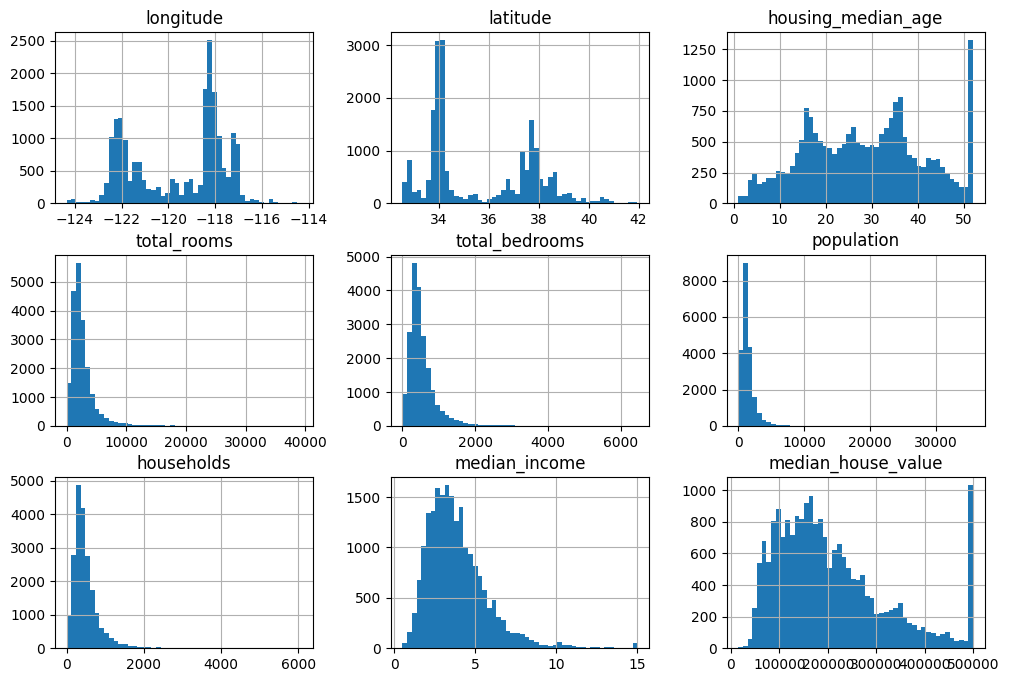

In [7]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

We see that not all districts are equal, income is not distributed equally. When we train the model we need to make sure that the training data set has observations from all income category districts.

In [8]:
housing = housing.assign(
    # Create categories of median income 1 (lowest) to 5 (highest).
    income_category=lambda df: pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
)

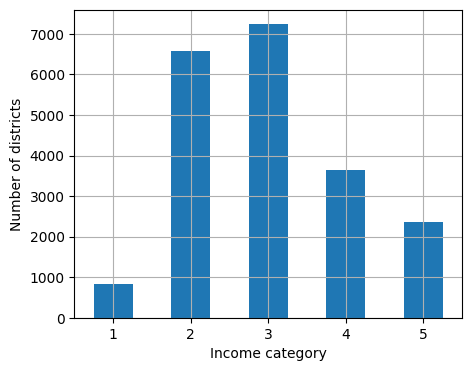

In [9]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

housing["income_category"].value_counts().sort_index().plot(kind="bar", grid=True, ax=ax)

ax.set(xlabel="Income category", ylabel="Number of districts")
plt.xticks(rotation=0)

plt.show()

# Create train and test sets

Check that stratification has worked

In [10]:
train, test = train_test_split(housing, test_size=0.2, stratify=housing["income_category"], random_state=42)


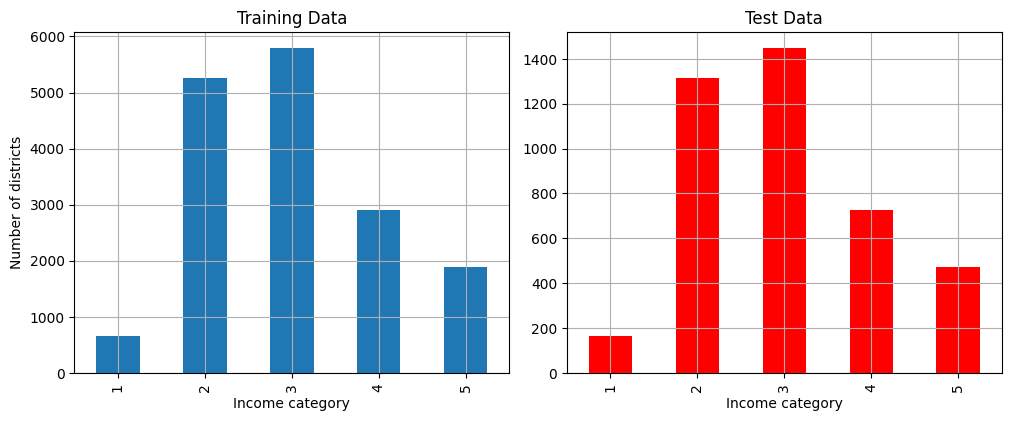

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.tight_layout()

train["income_category"].value_counts().sort_index().plot(kind="bar", grid=True, ax=axs[0])
test["income_category"].value_counts().sort_index().plot(kind="bar", grid=True, ax=axs[1], color="red")

axs[0].set(xlabel="Income category", ylabel="Number of districts", title="Training Data")
axs[1].set(xlabel="Income category", title="Test Data")

plt.show()

In [13]:
train, test = train.drop(columns=["income_category"]), test.drop(columns=["income_category"])

# Use training data to study correlations

Below we can see the map of California, the median house values (colour) are positively correlated with locations near the beach and negatively correlated with population (size of bubble).

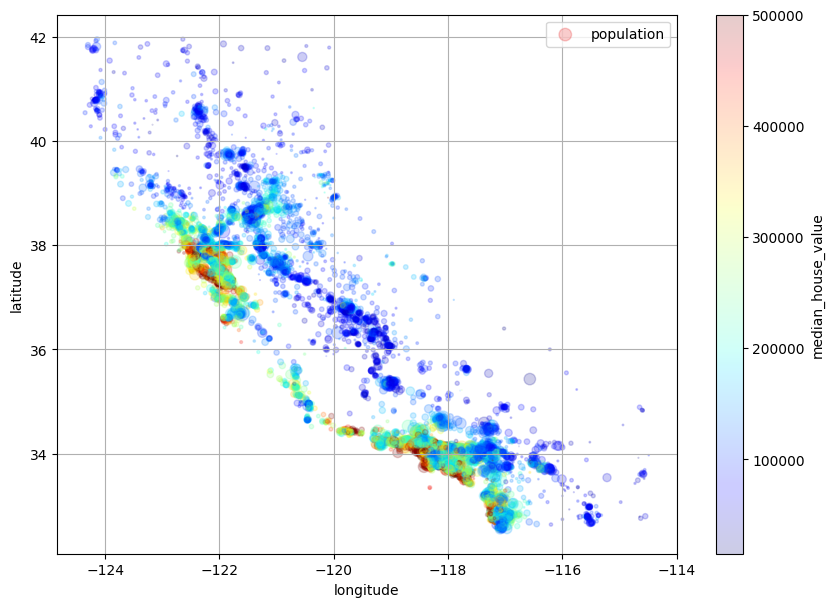

In [15]:
train.plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    s=train["population"] / 100, label="population",
    c="median_house_value", 
    cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7), alpha=0.2
)

plt.show()

The target is positively correlated with the median income and negatively correlated with latitude.

In [23]:
housing.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

# Pipeline

In [ ]:
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (pp. 148-149). O'Reilly Media. Kindle Edition. 